In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn

spectro_folder = Path('./spectrograms')
class SpectrogramDataset(Dataset):
    def __init__(self, transform, spectro_folder = spectro_folder):
        self.spectrogram_folders = list(spectro_folder.glob('spectrogram_*'))
        # self.transform = transforms.Compose([
        #     transforms.Resize((256, 256)),
        #     transforms.ToTensor(),
        #     # transforms.Lambda(lambda x: torch.flatten(x)), ])
        self.transform = transform

    def __len__(self):
        return len(self.spectrogram_folders)

    def __getitem__(self, idx):
        folder_path = self.spectrogram_folders[idx]

        # Load the spectrogram image
        img = Image.open(folder_path / 'spectrogram.png').convert('RGB')
        img = self.transform(img)

        # Load the label
        label_path = folder_path / 'label.txt'
        with open(label_path, 'r') as label_file:
            label = int(label_file.read().strip()) - 1

        return img, label

# # Path to the folder containing your spectrograms
# spectro_folder = Path('./spectrograms')

# # Create a custom dataset
# Data = SpectrogramDataset(spectro_folder)

# batch_size = 32

# train_set, test_set = train_test_split(Data, test_size = 0.2, shuffle = True)
# train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 3)
# test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 3)

In [1]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()
                                    ])

batch_size = 32
full_data = SpectrogramDataset(transform=train_transform)
train_valid_size = int(0.85 * len(full_data))
validation_size = len(full_data) - train_valid_size

generator1 = torch.Generator().manual_seed(0)
train_valid_dataset, validation_dataset = torch.utils.data.random_split(full_data, 
                                                                    [train_valid_size, validation_size],
                                                                    generator = generator1)


train_size = int(0.7 * len(full_data))
test_size = len(train_valid_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_valid_dataset,
                                                            [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers=3)

# train_set, test_set = train_test_split(full_data, test_size = 0.2, shuffle = True)
# train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 3)
# test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 3)



NameError: name 'transforms' is not defined

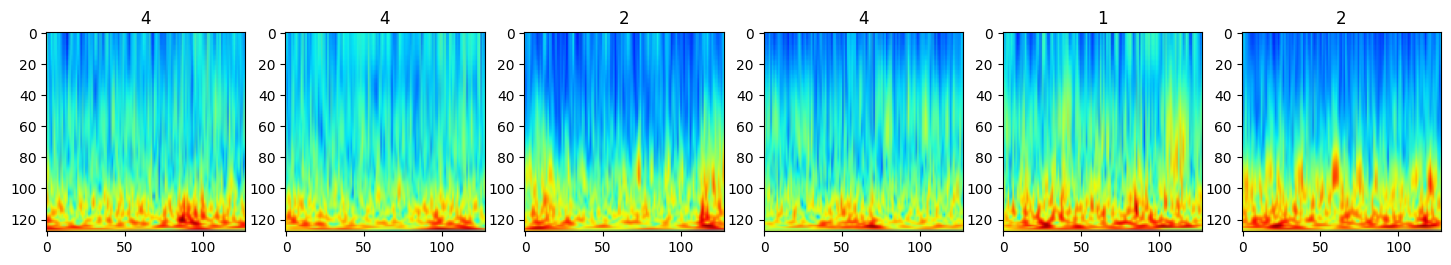

In [6]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))
    plt.title(labels[i].item())

plt.show()

In [7]:
def train(model, optimizer, loss_fn, num_epochs):
    # def loss_fun(output, target):
    #     return F.cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': [],
              'y_pred': [],
              'y_true': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
                       
            #Compute the loss
            loss = loss_fn(target, output)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()


            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(dim=1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        y_pred = []
        y_true = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fn(target, output).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(target.cpu().numpy())
        out_dict['train_acc'].append(train_correct/len(train_set))
        out_dict['test_acc'].append(test_correct/len(test_set))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        out_dict['y_pred'].append(y_pred)
        out_dict['y_true'].append(y_true)
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
def CrossEntropy(target, output):
    return F.cross_entropy(output, target)

In [10]:
import torchvision.models as models
model = models.vgg16(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[-1].in_features
model.classifier[6] = nn.Linear(num_features, 5)
model = model.to(device)
optimizer = torch.optim.AdamW(lr=1e-3, params=model.parameters(), weight_decay=0.1)
output_dict = train(model, optimizer, CrossEntropy, num_epochs=3)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 33%|███▎      | 1/3 [00:46<01:33, 46.57s/epoch]

Loss train: 1.360	 test: 1.358	 Accuracy train: 49.9%	 test: 44.1%


 67%|██████▋   | 2/3 [01:33<00:46, 46.51s/epoch]

Loss train: 1.277	 test: 1.276	 Accuracy train: 52.7%	 test: 44.9%


100%|██████████| 3/3 [02:19<00:00, 46.55s/epoch]

Loss train: 1.223	 test: 1.236	 Accuracy train: 52.3%	 test: 45.7%


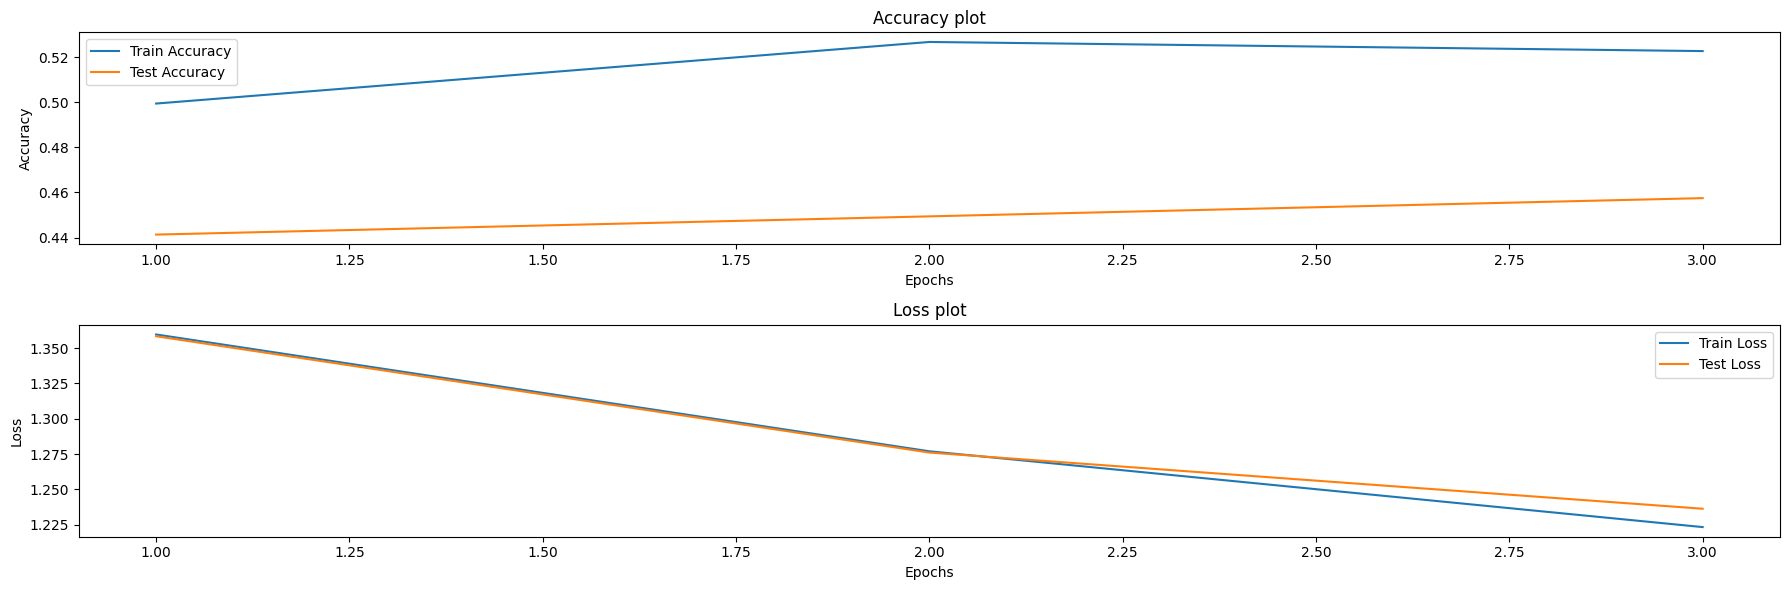

In [11]:
train_acc = output_dict['train_acc']
test_acc = output_dict['test_acc']
train_loss = output_dict['train_loss']
test_loss = output_dict['test_loss']
y_pred = output_dict['y_pred']
y_true = output_dict['y_true']
epochs = range(1, len(train_acc) + 1)

plt.subplot(2, 1, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
%store -r x_test
%store -r y_test

In [5]:
model.eval()
y_pred_validation = []
y_true_validation = []

for image in x_test:
    for label in y_test:
        image, label = image.to(device), label.to(device)
        with torch.no_grad():
            output = model(image)
            predicted = output.argmax(dim = 1)
        y_pred_validation.extend(predicted.cpu().numpy())
        y_true_validation.extend(predicted.cpu().numpy())


# for data, target in validation_loader:
#     data, target = data.to(device), target.to(device)
#     with torch.no_grad():
#         output = model(data)
#         predicted = output.argmax(dim = 1)
#     y_pred_validation.extend(predicted.cpu().numpy())
#     y_true_validation.extend(predicted.cpu().numpy())

NameError: name 'model' is not defined

In [22]:
y_pred = np.asarray(y_pred).reshape(-1)
y_true = np.asarray(y_true).reshape(-1)


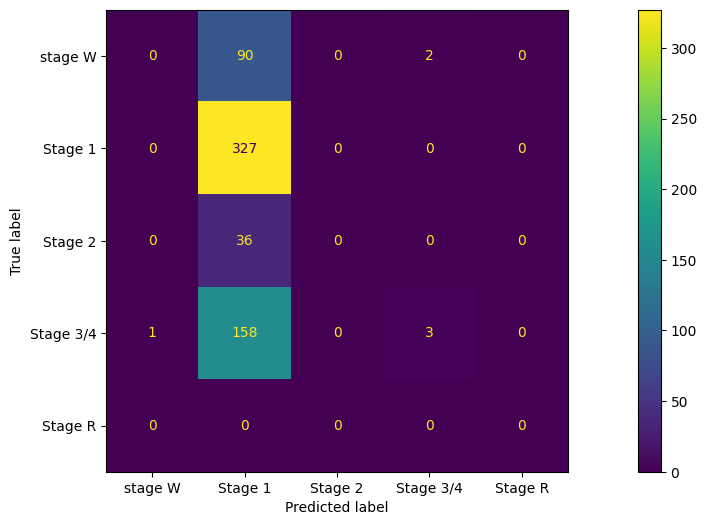

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["stage W", "Stage 1", "Stage 2", "Stage 3/4", "Stage R"])
disp.plot()
plt.show()


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['sleep stage W', 'sleep Stage 1', 'sleep Stage 2', 'Sleep Stage 3/4', 'Sleep Stage R']))

                 precision    recall  f1-score   support

  sleep stage W       0.75      0.02      0.05       123
  sleep Stage 1       0.00      0.00      0.00        93
  sleep Stage 2       0.45      1.00      0.62       327
Sleep Stage 3/4       0.00      0.00      0.00        36
  Sleep Stage R       0.38      0.02      0.04       162

       accuracy                           0.45       741
      macro avg       0.31      0.21      0.14       741
   weighted avg       0.40      0.45      0.29       741



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
